In [1]:
import os
import pandas as pd
import numpy as np
import ast
import random
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup
from imblearn.over_sampling import SMOTE

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset y carga de folds

In [2]:
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def cargar_dataset_completo(nombre_embedding, carpeta, base_dir='/content/drive/MyDrive/DatosTFG/embeddings_normalizados'):
    path = os.path.join(base_dir, carpeta, nombre_embedding)
    X = np.load(os.path.join(path, 'X.npy'))
    y = np.load(os.path.join(path, 'y.npy'))
    folds = np.load(os.path.join(path, 'folds.npy'))
    return X, y, folds

## Función para balancear el conjunto de entrenamiento y test

In [3]:
def balancear_con_smote(X_train, y_train):
    ns, sl, dim = X_train.shape
    X_flat = X_train.reshape(-1, dim)
    y_flat = np.repeat(y_train, sl)

    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_flat, y_flat)

    ns_res = len(y_res) // sl
    X_seq = X_res.reshape(ns_res, sl, dim)
    y_seq = y_res[::sl]

    return X_seq, y_seq


# Modelos:

#### Attention Pooling

In [4]:
class AttentionPooling(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        attn_weights = torch.softmax(self.attn(x), dim=1)
        return (x * attn_weights).sum(dim=1)


#### Positional encoging fijo

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


## LSTM

In [6]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=2, bidirectional=True, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.layer_norm = nn.LayerNorm(hidden_dim * (2 if bidirectional else 1))
        self.attn_pool = AttentionPooling(hidden_dim * (2 if bidirectional else 1))
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * (2 if bidirectional else 1), 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.layer_norm(out)
        out = self.attn_pool(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out.squeeze(1)


## GRU

In [7]:
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=2, bidirectional=True, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.layer_norm = nn.LayerNorm(hidden_dim * (2 if bidirectional else 1))
        self.attn_pool = AttentionPooling(hidden_dim * (2 if bidirectional else 1))
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * (2 if bidirectional else 1), 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.layer_norm(out)
        out = self.attn_pool(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out.squeeze(1)

## TRANSFORMER

In [8]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_layers=4, num_heads=16, dropout=0.5, max_len=100):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.pos_enc = PositionalEncoding(hidden_dim, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.attn_pool = AttentionPooling(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        B = x.size(0)
        x = self.input_proj(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.pos_enc(x)
        x = self.encoder(x)
        x = self.layer_norm(x)
        out = self.attn_pool(x)
        out = self.dropout(out)
        out = self.fc(out)
        return out.squeeze(1)

##Temporal Convutional Network

In [9]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                     dilation=dilation_size, padding=(kernel_size-1)*dilation_size,
                                     dropout=dropout)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.transpose(1, 2)
        y = self.network(x)
        return y.transpose(1, 2)

class TCNClassifier(nn.Module):
    def __init__(self, input_dim, num_channels=[128, 128, 256], kernel_size=3, dropout=0.3):
        super().__init__()
        self.tcn = TCN(input_dim, num_channels, kernel_size, dropout)
        self.attn_pool = AttentionPooling(num_channels[-1])
        self.fc = nn.Sequential(
            nn.Linear(num_channels[-1], 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out = self.tcn(x)
        out = self.attn_pool(out)
        out = self.fc(out)
        return out.squeeze(1)


## Entrenamiento base


In [10]:
def train_model(model,
                train_loader,
                val_loader,
                epochs=50,
                lr_rnn=1e-3,
                wd_rnn=1e-3,
                lr_transf=1e-4,
                wd_transf=5e-3,
                warmup_ratio=1e-1,
                patience=15):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    all_labels = torch.tensor([y for _, y in train_loader.dataset], dtype=torch.float32)
    n_pos = (all_labels == 1).sum().item()
    n_neg = (all_labels == 0).sum().item()
    pos_weight = torch.tensor([n_neg / n_pos], device=device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # detección de tipo de modelo
    is_transformer = hasattr(model, 'encoder')

    if is_transformer:
        optimizer = torch.optim.AdamW(model.parameters(),
                                      lr=lr_transf,
                                      weight_decay=wd_transf)
    else:
        optimizer = torch.optim.AdamW(model.parameters(),
                                      lr=lr_rnn,
                                      weight_decay=wd_rnn)

    if is_transformer:
        total_steps  = epochs * len(train_loader)
        warmup_steps = int(warmup_ratio * total_steps)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
        use_plateau = False
    else:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            factor=0.5,
            patience=5
        )
        use_plateau = True

    best_f1, counter, best_state = 0.0, 0, None

    for epoch in range(1, epochs + 1):
        model.train()
        train_losses = []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(X)
            loss   = criterion(logits, y)
            loss.backward()
            optimizer.step()
            if not use_plateau:
                scheduler.step()
            train_losses.append(loss.item())

        model.eval()
        y_true, y_pred, y_probs = [], [], []
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                logits = model(X).cpu()
                preds  = (torch.sigmoid(logits) > 0.5).int()
                y_pred += preds.tolist()
                y_true += y.tolist()
                y_probs.extend(torch.sigmoid(logits).cpu().numpy())

        acc = accuracy_score(y_true, y_pred)
        f1  = f1_score(y_true, y_pred)
        avg_loss = sum(train_losses) / len(train_losses)
        print(f"Epoch {epoch}/{epochs}  "
              f"TrainLoss={avg_loss:.4f}  "
              f"ValAcc={acc:.4f}  ValF1={f1:.4f}")

        # scheduler step para ReduceLROnPlateau
        if use_plateau:
            scheduler.step(f1)

        # early stopping basado en F1
        if f1 > best_f1:
            best_f1    = f1
            best_state = copy.deepcopy(model.state_dict())
            counter    = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"— Early stopping en epoch {epoch}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(device)
            logits = model(X).cpu()
            preds  = (torch.sigmoid(logits) > 0.5).int()
            y_pred += preds.tolist()
            y_true += y.tolist()
            y_probs.extend(torch.sigmoid(logits).cpu().numpy())

    report = classification_report(y_true, y_pred, digits=4)
    final_acc = accuracy_score(y_true, y_pred)
    final_f1  = f1_score(y_true, y_pred)

    return final_acc, final_f1, report, y_true, y_probs


# Curvas ROC y PR

In [11]:
def plot_roc_pr_curve(y_true, y_probs):
    assert np.all((y_probs >= 0) & (y_probs <= 1)), "Las probabilidades deben estar entre 0 y 1"

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = average_precision_score(y_true, y_probs)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (AP = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.show()

## Validación cruzada

In [12]:
def cross_validation(nombre_embedding, carpeta, modelo, usar_smote, n_folds=5, batch_size=32, epochs=50):
    X, y, folds = cargar_dataset_completo(nombre_embedding, carpeta)
    accs, f1s = [], []
    all_y_true, all_y_probs = [], []

    for eval_fold in range(n_folds):
        print(f"\n=== Evaluando fold {eval_fold}/{n_folds-1} ===")
        set_seed(42 + eval_fold)

        # Entrenar scaler con todos menos el fold de evaluación
        X_scaler = X[folds != eval_fold].reshape(-1, X.shape[-1])
        scaler = StandardScaler().fit(X_scaler)

        # Aplicar el scaler a todo el dataset
        X_scaled = X.reshape(-1, X.shape[-1])
        X_scaled = scaler.transform(X_scaled).reshape(X.shape)

        val_fold = (eval_fold + 1) % n_folds
        print(f"Validación con fold {val_fold}, evaluación con fold {eval_fold}")

        train_idx = (folds != eval_fold) & (folds != val_fold)
        val_idx   = folds == val_fold
        test_idx  = folds == eval_fold

        X_train, y_train = X_scaled[train_idx], y[train_idx]
        X_val,   y_val   = X_scaled[val_idx],   y[val_idx]
        X_test,  y_test  = X_scaled[test_idx],  y[test_idx]

        # Balancear entrenamiento si procede
        if usar_smote:
            X_train, y_train = balancear_con_smote(X_train, y_train)

        # Crear DataLoaders
        train_ds = SequenceDataset(X_train, y_train)
        val_ds   = SequenceDataset(X_val, y_val)
        test_ds  = SequenceDataset(X_test, y_test)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds, batch_size=batch_size)
        test_loader  = DataLoader(test_ds, batch_size=batch_size)

        # Inicializar modelo
        input_dim = X_train.shape[2]
        if modelo == 'LSTM':
            model = LSTMClassifier(input_dim)
        elif modelo == 'GRU':
            model = GRUClassifier(input_dim)
        elif modelo == 'Transformer':
            model = TransformerClassifier(input_dim)
        elif modelo == 'TCN':
            model = TCNClassifier(input_dim)
        else:
            raise ValueError("Modelo no válido. Usa 'LSTM', 'GRU', 'Transformer' o 'TCN'.")

        # Entrenar y validar
        acc_val, f1_val, report_val, _, _ = train_model(model, train_loader, val_loader, epochs=epochs)

        # Evaluación final con test
        model.eval()
        y_true, y_pred, y_probs = [], [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(next(model.parameters()).device)
                logits = model(X_batch).cpu()
                preds  = (torch.sigmoid(logits) > 0.5).int()
                y_pred += preds.tolist()
                y_true += y_batch.tolist()
                y_probs.extend(torch.sigmoid(logits).cpu().numpy())

        acc_test = accuracy_score(y_true, y_pred)
        f1_test  = f1_score(y_true, y_pred)
        print(f"Fold {eval_fold} - Test Accuracy: {acc_test:.4f} | Test F1: {f1_test:.4f}")

        accs.append(acc_test)
        f1s.append(f1_test)
        all_y_true.extend(y_true)
        all_y_probs.extend(y_probs)

    print("\n=== Resultados Globales ===")
    print(f"Accuracy promedio: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    print(f"F1 promedio: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

    plot_roc_pr_curve(np.array(all_y_true), np.array(all_y_probs))


## Ejecución

Ejecutando cross_validation para embedding: fusion_slowfast4x16nln_i3dnln101, modelo: Transformer

=== Evaluando fold 0/4 ===
Validación con fold 1, evaluación con fold 0
Epoch 1/50  TrainLoss=0.6900  ValAcc=0.6073  ValF1=0.5743
Epoch 2/50  TrainLoss=0.6762  ValAcc=0.6804  ValF1=0.6500
Epoch 3/50  TrainLoss=0.6262  ValAcc=0.6986  ValF1=0.6796
Epoch 4/50  TrainLoss=0.5046  ValAcc=0.7763  ValF1=0.7487
Epoch 5/50  TrainLoss=0.4282  ValAcc=0.7900  ValF1=0.7527
Epoch 6/50  TrainLoss=0.3411  ValAcc=0.7991  ValF1=0.7582
Epoch 7/50  TrainLoss=0.2289  ValAcc=0.7900  ValF1=0.7629
Epoch 8/50  TrainLoss=0.1862  ValAcc=0.7991  ValF1=0.7528
Epoch 9/50  TrainLoss=0.1946  ValAcc=0.8128  ValF1=0.7630
Epoch 10/50  TrainLoss=0.1816  ValAcc=0.8037  ValF1=0.7749
Epoch 11/50  TrainLoss=0.1547  ValAcc=0.8174  ValF1=0.7826
Epoch 12/50  TrainLoss=0.0945  ValAcc=0.7991  ValF1=0.7609
Epoch 13/50  TrainLoss=0.0827  ValAcc=0.8128  ValF1=0.7657
Epoch 14/50  TrainLoss=0.0642  ValAcc=0.8356  ValF1=0.8000
Epoch 15/50 

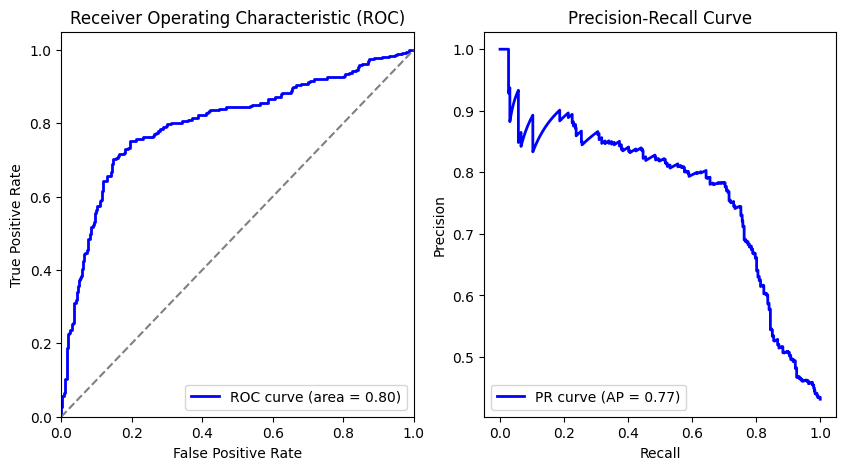

In [13]:
carpeta = "32f_6o"    # Ventana temporal (nombre de la carpeta donde se encuentran los embeddings procesados): 32f_0o, 16f_0o, 8f_0o, 32f_2o, 32f_4o ó 32f_6o

nombres_embedding = ["fusion_slowfast4x16nln_i3dnln101"]    # Embeddings a probar
modelos = ["Transformer"]   # Modelos a probar: GRU, LSTM, Transformer y TCN

usar_smote = True   # Balancear conjunto de entrenamiento o no

for nombre_embedding in nombres_embedding:
    for modelo in modelos:
        print(f"Ejecutando cross_validation para embedding: {nombre_embedding}, modelo: {modelo}")
        cross_validation(nombre_embedding, carpeta, modelo, usar_smote)